##Neccessary Imports

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
import numpy as np
import json
from pathlib import Path
import random
from typing import List, Dict, Tuple

##Load Data

In [ ]:
def load_arc_eval(challenges_path, solutions_path):
    challenges = json.load(open(challenges_path))
    solutions  = json.load(open(solutions_path))
    return challenges, solutions

In [ ]:
train_challenges, train_solutions = load_arc_eval("/content/arc-agi_training_challenges.json",
                                                  "/content/arc-agi_training_solutions.json")

eval_challenges, eval_solutions = load_arc_eval("/content/arc-agi_evaluation_challenges.json",
                                                  "/content/arc-agi_evaluation_solutions.json")

In [ ]:
print("Total number of train challenges: ", len(train_challenges.keys()))
print("Total number of train solutions: ", len(train_solutions.keys()))
print("Total number of eval challenges: ", len(eval_challenges.keys()))
print("Total number of eval solutions: ", len(eval_solutions.keys()))

Total number of train challenges:  386
Total number of train solutions:  386
Total number of eval challenges:  381
Total number of eval solutions:  381


##Visualizations

In [ ]:
ARC_PALETTE = np.array([
    [  0,   0,   0],   # 0 black
    [255,   0,   0],   # 1 red
    [  0, 255,   0],   # 2 green
    [255, 255,   0],   # 3 yellow
    [  0,   0, 255],   # 4 blue
    [255,   0, 255],   # 5 magenta
    [  0, 255, 255],   # 6 cyan
    [255, 255, 255],   # 7 white
    [128, 128, 128],   # 8 gray
    [128,   0,   0],   # 9 dark red
], dtype=np.uint8)

ARC_CMAP = ListedColormap(ARC_PALETTE / 255.0, name="arc")
ARC_NORM = BoundaryNorm(np.arange(-0.5, 10.5, 1), ARC_CMAP.N)

In [ ]:
def plot_grid(grid, title="", ax=None, cmap=ARC_CMAP, norm=ARC_NORM):
    arr = np.array(grid, dtype=int)
    if ax is None:
        fig, ax = plt.subplots(figsize=(3.2, 3.2))
    ax.imshow(arr, interpolation="nearest", cmap=cmap, norm=norm)
    ax.set_title(title)
    ax.set_xticks([]); ax.set_yticks([])
    # light cell borders
    h, w = arr.shape
    for x in range(w + 1):
        ax.axvline(x - 0.5, linewidth=0.5, color="white", alpha=0.6)
    for y in range(h + 1):
        ax.axhline(y - 0.5, linewidth=0.5, color="white", alpha=0.6)

In [ ]:
def _extract_solution(solutions, j):
    """
    Accepts either:
      - list aligned to tests: solutions[j]
      - dict like {'test': [{'output': ...}, ...]}
    Returns the j-th solution grid or None.
    """
    if solutions is None:
        return None
    if isinstance(solutions, dict) and "test" in solutions:
        return solutions["test"][j]["output"]
    if isinstance(solutions, list):
        return solutions[j]
    return None

In [ ]:
def visualize_task(task, solutions=None, *, show_train=True, show_test=True):
    """
    Usage:
      visualize_task(train_challenges["007bbfb7"])                       # only train pairs
      visualize_task(train_challenges["007bbfb7"], train_solutions["007bbfb7"])  # + solutions
    """
    trains = task.get("train", [])
    tests  = task.get("test", [])

    if show_train:
        for i, p in enumerate(trains, 1):
            fig, axes = plt.subplots(1, 2, figsize=(7.5, 3.5))
            plot_grid(p["input"],  f"Train {i} — INPUT",  ax=axes[0])
            plot_grid(p["output"], f"Train {i} — OUTPUT", ax=axes[1])
            plt.tight_layout(); plt.show()

    if show_test and tests:
        for j, t in enumerate(tests):
            sol = _extract_solution(solutions, j) if solutions is not None else None
            if sol is None:
                fig, ax = plt.subplots(1, 1, figsize=(3.5, 3.5))
                plot_grid(t["input"], f"Test {j+1} — INPUT", ax=ax)
                plt.tight_layout(); plt.show()
            else:
                fig, axes = plt.subplots(1, 2, figsize=(7.5, 3.5))
                plot_grid(t["input"], f"Test {j+1} — INPUT",    ax=axes[0])
                plot_grid(sol,        f"Test {j+1} — SOLUTION", ax=axes[1])
                plt.tight_layout()
                plt.show()

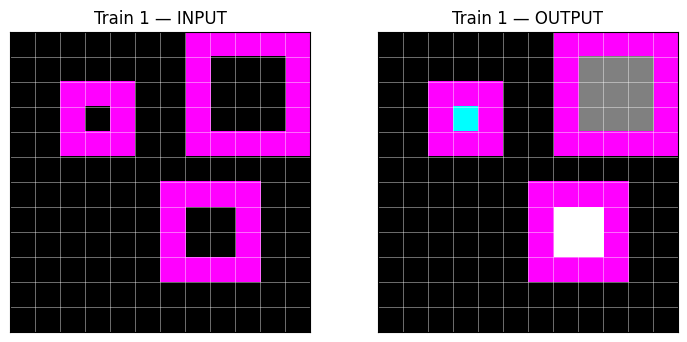

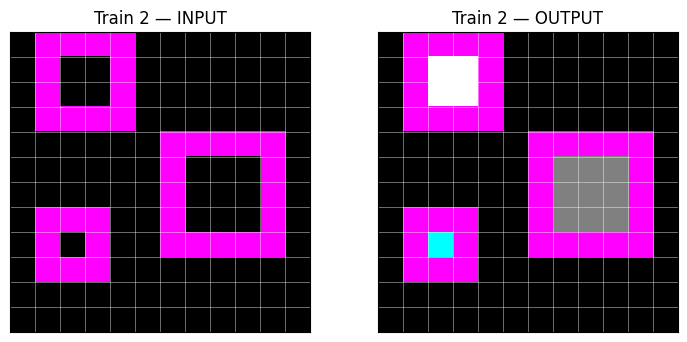

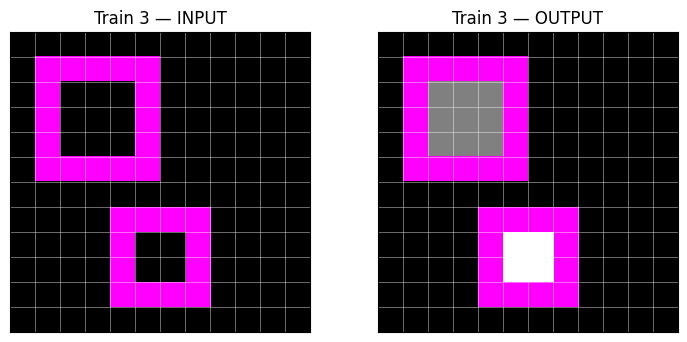

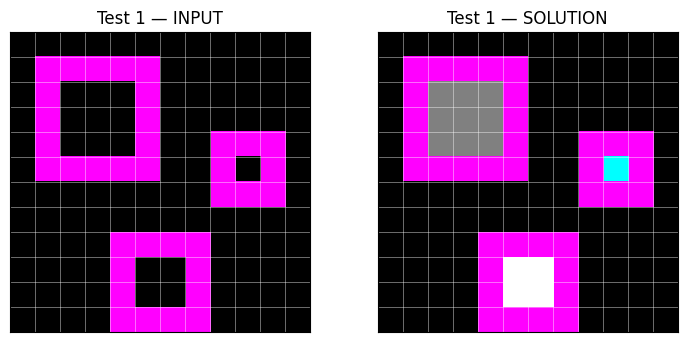

In [ ]:
visualize_task(train_challenges["c0f76784"], train_solutions['c0f76784'])

##Finetuning Dataset



###REARC Data

We will create ARC type dataset from RE-ARC (from Michael Hodel).

In [ ]:
!git clone https://github.com/michaelhodel/re-arc.git

Cloning into 're-arc'...
remote: Enumerating objects: 60, done.
remote: Counting objects: 100% (33/33), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 60 (delta 25), reused 19 (delta 18), pack-reused 27 (from 1)
Receiving objects: 100% (60/60), 55.76 MiB | 30.80 MiB/s, done.
Resolving deltas: 100% (27/27), done.


In [ ]:
import sys
sys.path.append("/content/re-arc")

In [ ]:
from main import generate_dataset, demo_generator

In [ ]:
generate_dataset(
    path = "out_rearc",
    seed = 52,
    n_examples = 20)

task 400/400, example 20/20: 100%|██████████| 400/400 [01:55<00:00,  3.47it/s]


In [ ]:
def rearc_file_to_arc_task(path, n_train=2, n_test=1):
    pairs = json.load(open(path))
    random.shuffle(pairs)
    train_pairs = pairs[:n_train]
    test_pairs  = pairs[n_train:n_train+n_test]
    task = {
        "train": [{"input": p["input"], "output": p["output"]} for p in train_pairs],
        "test":  [{"input": p["input"]} for p in test_pairs],
    }
    solutions = {"test": [{"output": p["output"]} for p in test_pairs]}
    return task, solutions

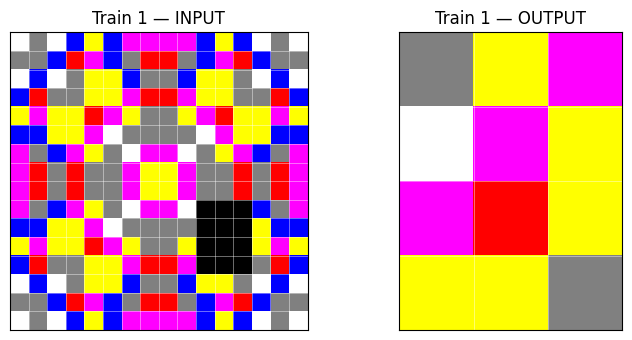

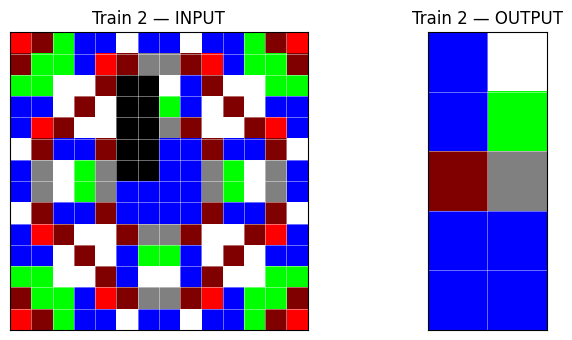

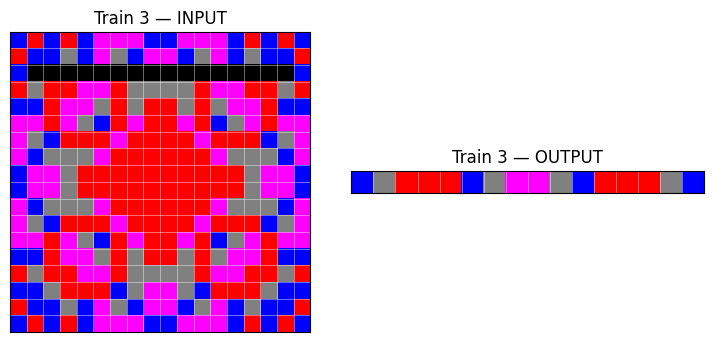

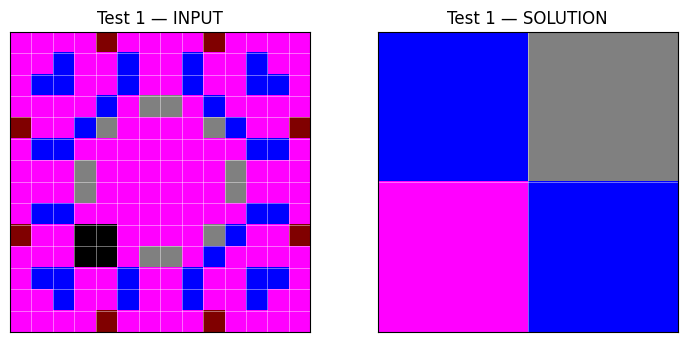

In [ ]:
task_path = "/content/out_rearc/tasks/9ecd008a.json"  # pick any file produced by generate_dataset
task, sols = rearc_file_to_arc_task(task_path, n_train=3, n_test=1)
visualize_task(task, sols)

###Create ARC + REARC Data

In [ ]:
def load_json(path):
    with open(path, "r") as f:
        return json.load(f)

def chunk_list(lst, size):
    for i in range(0, len(lst), size):
        yield lst[i:i+size]

In [ ]:
def build_arc_portion(challenges_path, solutions_path):
    """
    Pure builder: returns a dict of ARC tasks. Does not mutate external state.
    """
    chal = load_json(challenges_path)          # {task_id: {"train":[...], "test":[...]}}
    sols = load_json(solutions_path)           # {task_id: [output_grid, ...]}
    out = {}

    for tid, task in chal.items():
        key = f"arc_{tid}"
        pairs = []
        for p in task.get("train", []):
            pairs.append({"input": p["input"], "output": p["output"], "split": "train"})

        test_inputs = [p["input"] for p in task.get("test", [])]
        test_outputs = sols.get(tid, [])
        n = min(len(test_inputs), len(test_outputs))
        for i in range(n):
            pairs.append({"input": test_inputs[i], "output": test_outputs[i], "split": "test"})

        if len(test_inputs) != len(test_outputs):
            print(f"⚠️ ARC {tid}: test inputs ({len(test_inputs)}) != solutions ({len(test_outputs)}); keeping {n}")

        out[key] = {"source": "arc", "base": tid, "pairs": pairs}  # 'base' for provenance
    return out

In [ ]:
def build_rearc_portion(rearc_folder, chunk_size=5):
    """
    Pure builder: returns a dict of RE-ARC tasks (with chunking). No external mutation.
    """
    out = {}
    rearc_dir = Path(rearc_folder)
    for fp in rearc_dir.glob("*.json"):
        data = load_json(fp)

        # Normalize into (tid, examples_list) pairs
        items = []
        if isinstance(data, dict):
            for tid, examples in data.items():
                items.append((tid, examples))
        elif isinstance(data, list):
            items.append((fp.stem, data))
        else:
            print(f"⚠️ Skipping {fp.name}: unexpected JSON type {type(data)}")
            continue

        # Process each (tid, examples) with chunking
        for tid, examples in items:
            pairs_all = [{"input": ex["input"], "output": ex["output"], "split": "all"} for ex in examples]
            chunks = list(chunk_list(pairs_all, chunk_size))

            if len(chunks) == 1:
                # single chunk: keep simple name
                key = f"rearc_{tid}"
                i = 1
                while key in out:
                    key = f"rearc_{tid}_{i}"; i += 1
                out[key] = {"source": "rearc", "base": tid, "pairs": chunks[0]}
            else:
                # multiple chunks: suffix chunk index, 2-digit
                for idx, chunk in enumerate(chunks, start=1):
                    key = f"rearc_{tid}__chunk{idx:02d}"
                    i = 1
                    while key in out:
                        key = f"rearc_{tid}__chunk{idx:02d}_{i}"; i += 1
                    out[key] = {"source": "rearc", "base": tid, "pairs": chunk}
    return out

In [ ]:
def build_big_file(arc_challenges_path=None, arc_solutions_path=None,
                   rearc_folder=None, output_path="combined_arc_rearc.json",
                   chunk_size=5, compact=True):
    # Build parts (pure)
    arc_part = {}
    rearc_part = {}

    if arc_challenges_path and arc_solutions_path and Path(arc_challenges_path).exists():
        arc_part = build_arc_portion(arc_challenges_path, arc_solutions_path)

    if rearc_folder and Path(rearc_folder).exists():
        rearc_part = build_rearc_portion(rearc_folder, chunk_size=chunk_size)

    # Sanity: we don't expect overlap; fail fast if any
    overlap = set(arc_part) & set(rearc_part)
    if overlap:
        raise KeyError(f"Duplicate keys: {sorted(list(overlap))[:10]}")

    # Minimal merge
    combined = {}
    combined.update(arc_part)
    combined.update(rearc_part)

    # Write
    with open(output_path, "w") as f:
        if compact:
            json.dump(combined, f, separators=(",", ":"))
        else:
            json.dump(combined, f, indent=2)

    print(f"✅ Wrote {len(combined)} tasks to {output_path}")
    return combined

In [ ]:
combined = build_big_file(
    arc_challenges_path="/content/arc-agi_training_challenges.json",
    arc_solutions_path="/content/arc-agi_training_solutions.json",
    rearc_folder="/content/out_rearc/tasks",
    output_path="combined_arc_rearc.json",
    chunk_size=5,
    compact=True           # compact JSON (no pretty-print)
)

✅ Wrote 1986 tasks to combined_arc_rearc.json


###Inspect Dataset

In [ ]:
import json
from collections import Counter
from pathlib import Path

PATH = "/content/combined_arc_rearc.json"  # change if needed
data = json.load(open(PATH))

print("Tasks:", len(data))
print("Sample keys:", list(sorted(data))[:8])

src_counts   = Counter(t["source"] for t in data.values())
split_counts = Counter(p["split"] for t in data.values() for p in t["pairs"])
total_pairs  = sum(len(t["pairs"]) for t in data.values())
print("By source:", src_counts)
print("Pairs total:", total_pairs, "| By split:", split_counts)


Tasks: 1986
Sample keys: ['arc_007bbfb7', 'arc_00d62c1b', 'arc_017c7c7b', 'arc_025d127b', 'arc_045e512c', 'arc_0520fde7', 'arc_05269061', 'arc_05f2a901']
By source: Counter({'rearc': 1600, 'arc': 386})
Pairs total: 9613 | By split: Counter({'all': 8000, 'train': 1227, 'test': 386})


In [ ]:
import pandas as pd
from collections import Counter

rows = []
for k, t in data.items():
    c = Counter(p["split"] for p in t["pairs"])
    rows.append({
        "task": k,
        "source": t["source"],
        "base": t.get("base", ""),
        "n_pairs": len(t["pairs"]),
        "n_train": c.get("train", 0),
        "n_test":  c.get("test", 0),
        "n_all":   c.get("all", 0),
    })

df = pd.DataFrame(rows).sort_values(["source", "task"]).reset_index(drop=True)
df.head(20)  # show first 20

,task,source,base,n_pairs,n_train,n_test,n_all
0,arc_007bbfb7,arc,007bbfb7,6,5,1,0
1,arc_00d62c1b,arc,00d62c1b,6,5,1,0
2,arc_017c7c7b,arc,017c7c7b,4,3,1,0
3,arc_025d127b,arc,025d127b,3,2,1,0
4,arc_045e512c,arc,045e512c,4,3,1,0
5,arc_0520fde7,arc,0520fde7,4,3,1,0
6,arc_05269061,arc,05269061,4,3,1,0
7,arc_05f2a901,arc,05f2a901,4,3,1,0
8,arc_06df4c85,arc,06df4c85,4,3,1,0
9,arc_08ed6ac7,arc,08ed6ac7,3,2,1,0


In [ ]:
import random

def show_task(task_id, n=1, rows_preview=3):
    t = data[task_id]
    print(f"\nTask: {task_id} | source={t['source']} | base={t.get('base','')}")
    print(f"Pairs: {len(t['pairs'])}")
    for i, p in enumerate(t["pairs"][:n], 1):
        H_in, W_in  = len(p["input"]),  len(p["input"][0])
        H_out, W_out= len(p["output"]), len(p["output"][0])
        print(f"\n#{i} split={p['split']} | in={H_in}x{W_in} -> out={H_out}x{W_out}")
        print("input (head):",  p["input"][:rows_preview])
        print("output (head):", p["output"][:rows_preview])

# pick a key and preview
some_key = random.choice(list(data.keys()))
show_task(some_key, n=8) #Choose n greater than chunk size


Task: rearc_aabf363d__chunk04 | source=rearc | base=aabf363d
Pairs: 5

#1 split=all | in=19x26 -> out=19x26
input (head): [[7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7], [7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 2, 2, 2, 2, 2, 2, 7, 7, 7], [7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 2, 7, 2, 2, 2, 7, 7, 7, 7]]
output (head): [[7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7], [7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 7, 7, 7], [7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8, 7, 8, 8, 8, 7, 7, 7, 7]]

#2 split=all | in=9x21 -> out=9x21
input (head): [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0]]
output (head): [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9

###Data Augmentation

In [ ]:
def rot90(g):      return [list(row) for row in zip(*g[::-1])]
def rot180(g):     return [row[::-1] for row in g[::-1]]
def rot270(g):     return [list(row) for row in zip(*g)][::-1]
def flipH(g):      return [row[::-1] for row in g]
def flipV(g):      return g[::-1]
def transpose(g):  return [list(row) for row in zip(*g)]

_OPS = {
    "rot90": rot90, "rot180": rot180, "rot270": rot270,
    "flipH": flipH, "flipV": flipV, "transpose": transpose,
}

def apply_op(grid, op):
    return _OPS[op](grid)

In [ ]:
def _transform_all_pairs(task: dict, op: str):
    """Transform ALL pairs in a task (preserves each pair's split tag)."""
    out = []
    for p in task["pairs"]:
        out.append({
            "input":  apply_op(p["input"],  op),
            "output": apply_op(p["output"], op),
            "split":  p["split"],
            "aug":    {"type": "geom", "op": op}
        })
    return out

In [ ]:
def build_geometric_augmented_data(
    combined: dict,
    *,
    include_rotations: bool,
    include_flips: bool,
    include_transpose: bool,
    prefix: str = "aug__",
) -> dict:
    """
    Pure builder: for each original task, create ONE new task per selected transform.
    Each new task contains ALL transformed pairs from that task.
    """
    ops = []
    if include_rotations: ops += ["rot90","rot180","rot270"]
    if include_flips:     ops += ["flipH","flipV"]
    if include_transpose: ops += ["transpose"]
    if not ops:
        return {}

    aug_part = {}
    for orig_key in sorted(combined.keys()):
        base_task = combined[orig_key]
        for op in ops:
            new_pairs = _transform_all_pairs(base_task, op)
            if not new_pairs:
                continue

            new_task = {
                "source": base_task["source"],
                "base":   base_task.get("base",""),
                "pairs":  new_pairs,
            }

            # Name like: aug__<orig_key>__<op>, ensure no collision
            base_name = f"{prefix}{orig_key}__{op}"
            name = base_name
            i = 1
            while name in combined or name in aug_part:
                name = f"{base_name}__dup{i:02d}"
                i += 1

            aug_part[name] = new_task

    return aug_part

In [ ]:
import json

combined = json.load(open("combined_arc_rearc.json"))

aug_part = build_geometric_augmented_data(
    combined,
    include_rotations=True,
    include_flips=True,
    include_transpose=True,
    prefix="aug__",
)

# sanity: no overlap with originals expected
overlap = set(combined) & set(aug_part)
assert not overlap, f"Unexpected duplicate keys: {sorted(list(overlap))[:10]}"

combined_plus_aug = {**combined, **aug_part}
with open("combined_with_geom_aug.json", "w") as f:
    json.dump(combined_plus_aug, f, separators=(",", ":"))

print(f"Original: {len(combined)} | Augmented tasks: {len(aug_part)} | Total: {len(combined_plus_aug)}")

Original: 1986 | Augmented tasks: 11916 | Total: 13902


###Inspect Augmented Dataset

In [ ]:
# --- helpers to adapt our combined schema -> visualize_task's schema ---

def _combined_to_arc_style(task_dict):
    """
    Convert a combined-schema task {"pairs":[...]} into the shape expected by visualize_task:
      {"train":[{"input":...,"output":...}, ...], "test":[{"input":...}, ...]}
    We map:
      - splits 'train' and 'all' -> visualize_task's 'train'
      - split  'test'            -> visualize_task's 'test' (inputs only)
    Also returns a 'solutions' list for test pairs so visualize_task can show solutions.
    """
    trains = [{"input": p["input"], "output": p["output"]}
              for p in task_dict["pairs"] if p["split"] in ("train", "all")]
    test_inputs  = [{"input": p["input"]} for p in task_dict["pairs"] if p["split"] == "test"]
    test_solutions = [p["output"] for p in task_dict["pairs"] if p["split"] == "test"]
    # visualize_task expects 'solutions' optionally; pass None if there are no test pairs
    solutions = test_solutions if len(test_solutions) > 0 else None
    return {"train": trains, "test": test_inputs}, solutions

def list_augmented_keys_for(combined, base_key):
    """Find all augmented tasks derived from base_key (e.g., aug__<base_key>__rot90, ...)."""
    prefix = f"aug__{base_key}__"
    return sorted([k for k in combined.keys() if k.startswith(prefix)])

def visualize_base_and_augmented(combined, base_key, *, show_train=True, show_test=True):
    """
    Uses your visualize_task(...) function to display:
      1) the original task (ARC or RE-ARC)
      2) all associated augmented tasks (rot/flip/transpose variants)
    """
    # 1) base/original
    base_task = combined[base_key]
    task_arc_shape, sols = _combined_to_arc_style(base_task)
    print(f"\n=== BASE TASK: {base_key} | source={base_task['source']} | pairs={len(base_task['pairs'])} ===")
    visualize_task(task_arc_shape, sols, show_train=show_train, show_test=show_test)

    # 2) augmented siblings
    aug_keys = list_augmented_keys_for(combined, base_key)
    print(f"\nFound {len(aug_keys)} augmented tasks for {base_key}")
    for k in aug_keys:
        t = combined[k]
        t_arc_shape, sols_t = _combined_to_arc_style(t)
        # try to extract the op from the key suffix for a nicer header
        op = k.split("__")[-1]
        print(f"\n--- AUGMENTED: {k} (op={op}) | pairs={len(t['pairs'])} ---")
        visualize_task(t_arc_shape, sols_t, show_train=show_train, show_test=show_test)


=== BASE TASK: rearc_9ecd008a__chunk01 | source=rearc | pairs=5 ===


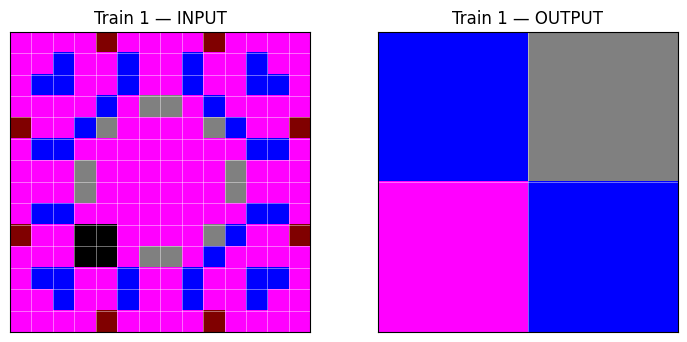

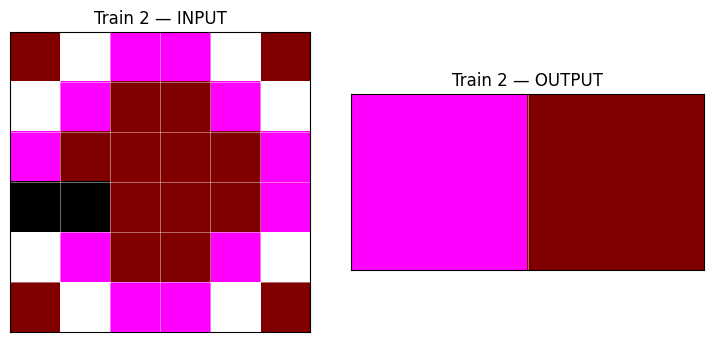

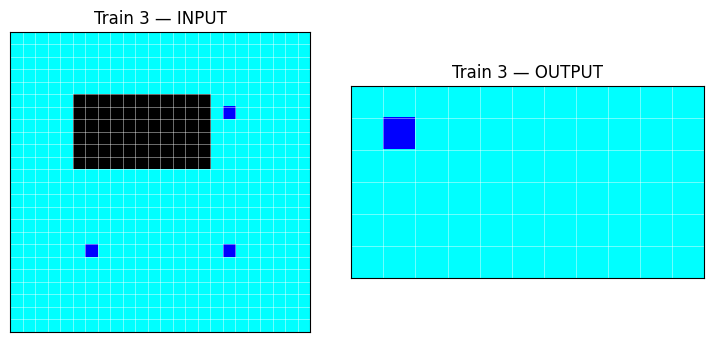

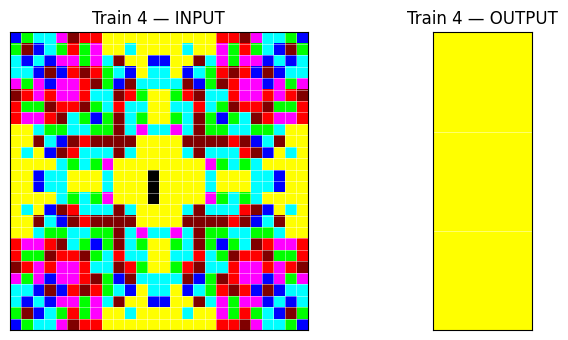

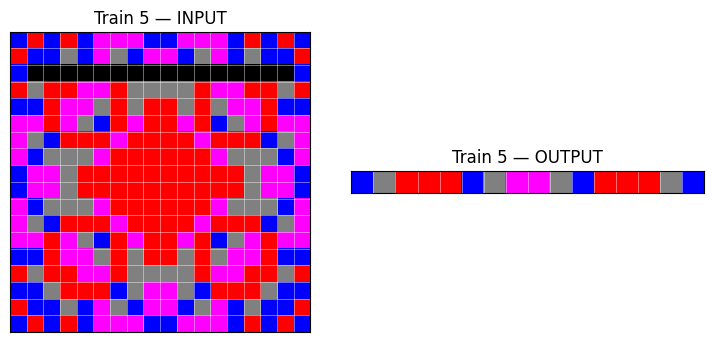


Found 6 augmented tasks for rearc_9ecd008a__chunk01

--- AUGMENTED: aug__rearc_9ecd008a__chunk01__flipH (op=flipH) | pairs=5 ---


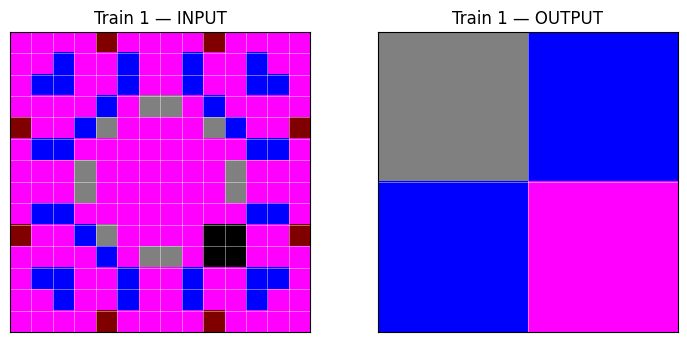

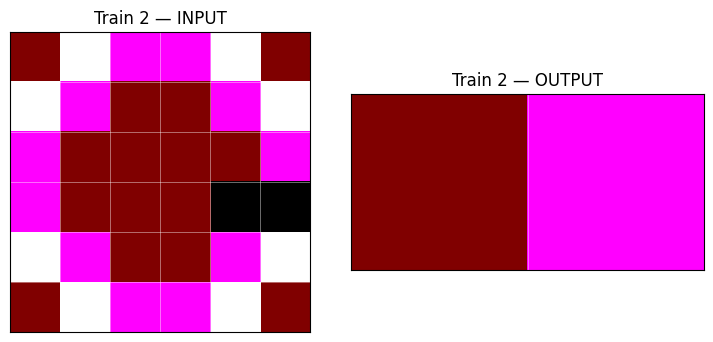

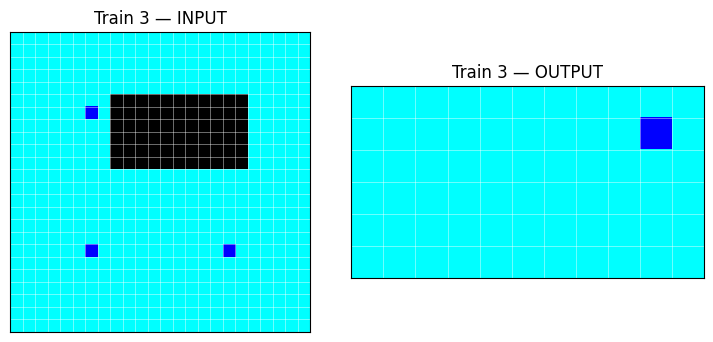

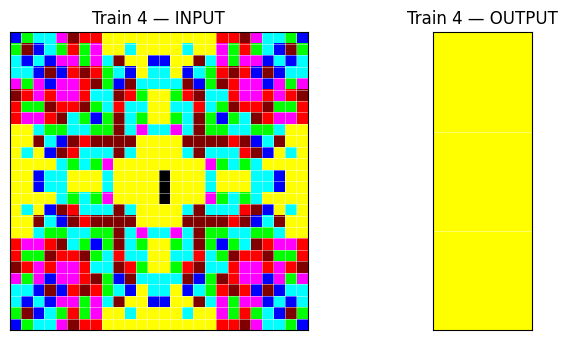

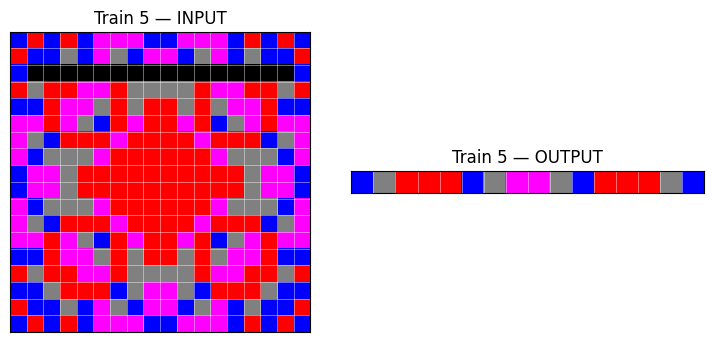


--- AUGMENTED: aug__rearc_9ecd008a__chunk01__flipV (op=flipV) | pairs=5 ---


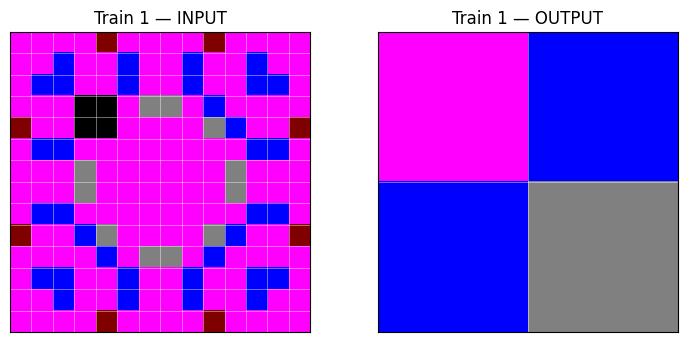

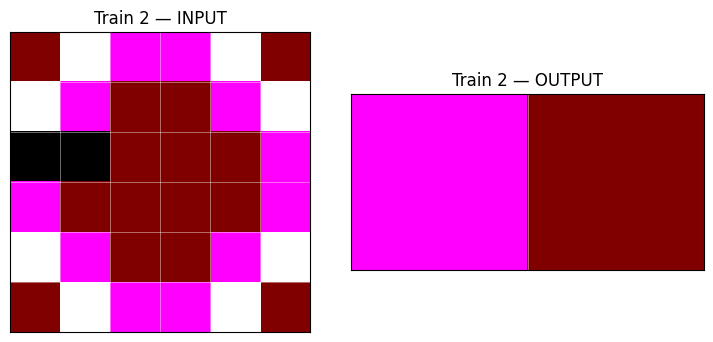

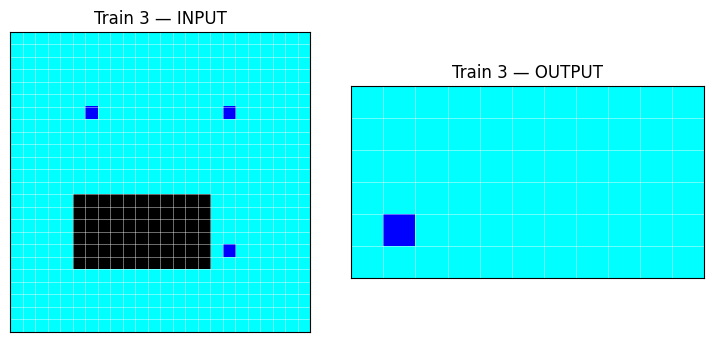

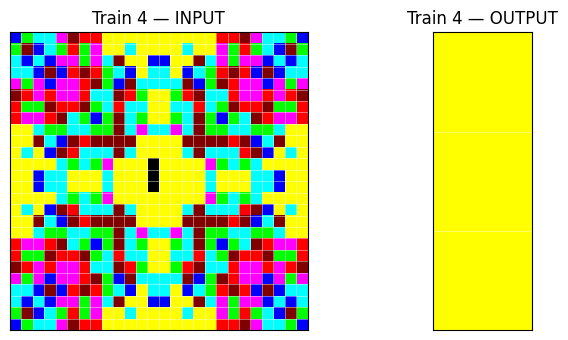

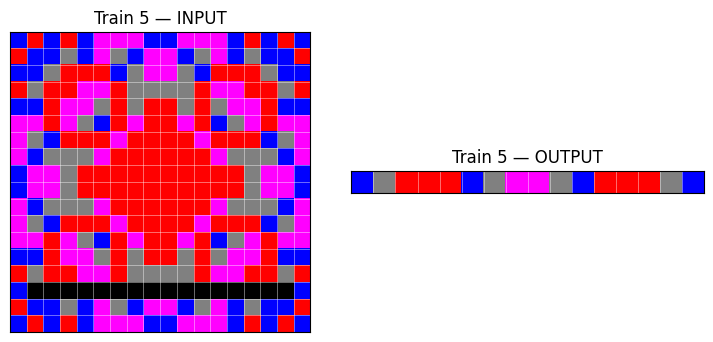


--- AUGMENTED: aug__rearc_9ecd008a__chunk01__rot180 (op=rot180) | pairs=5 ---


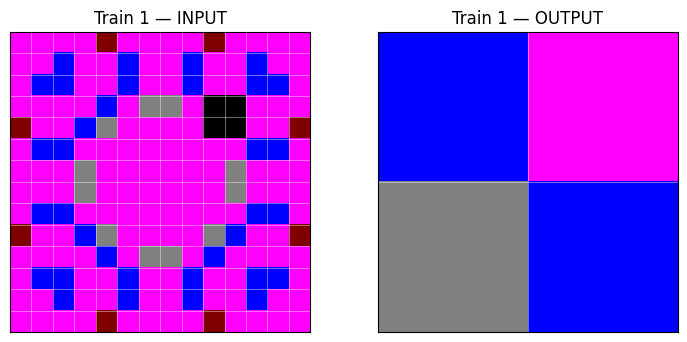

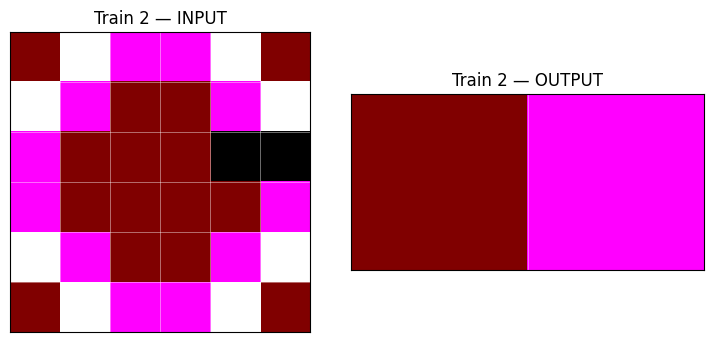

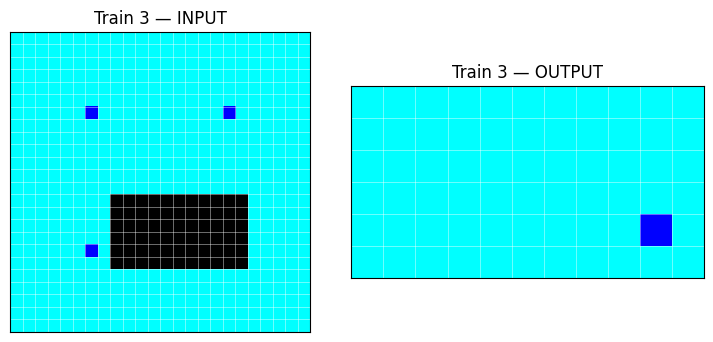

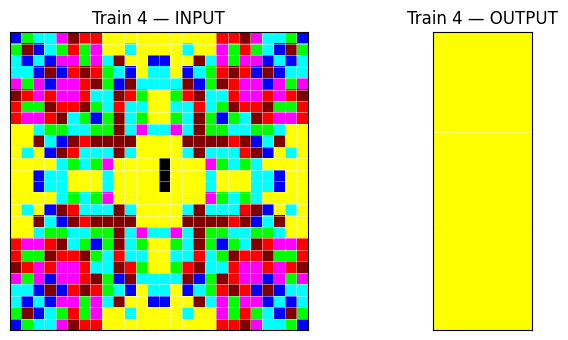

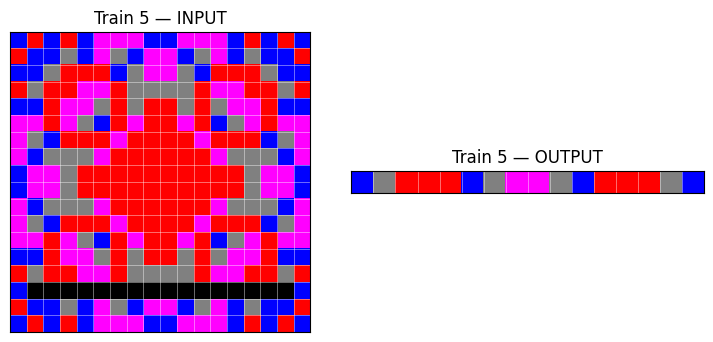


--- AUGMENTED: aug__rearc_9ecd008a__chunk01__rot270 (op=rot270) | pairs=5 ---


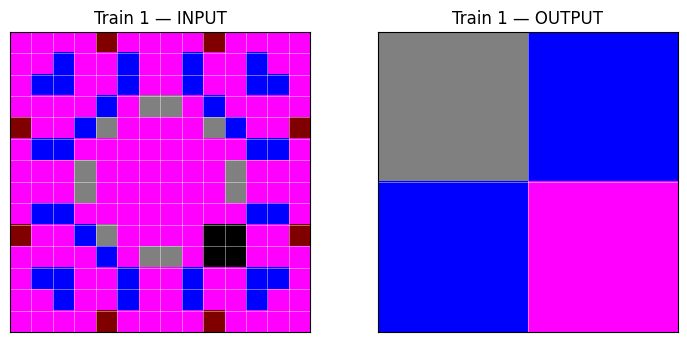

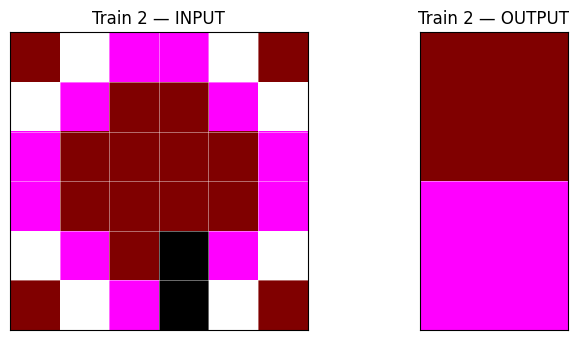

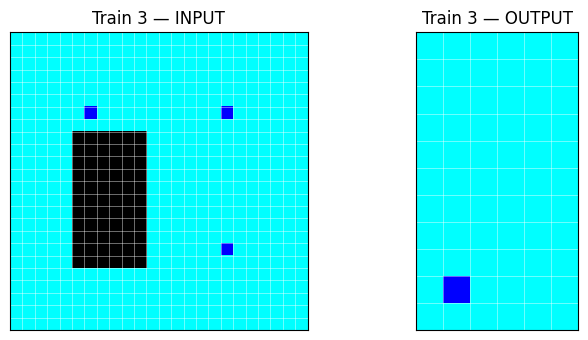

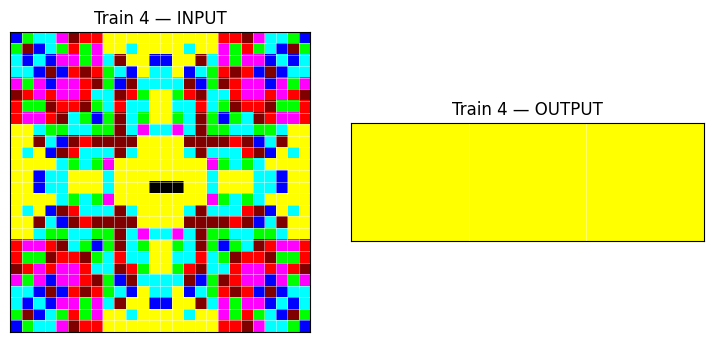

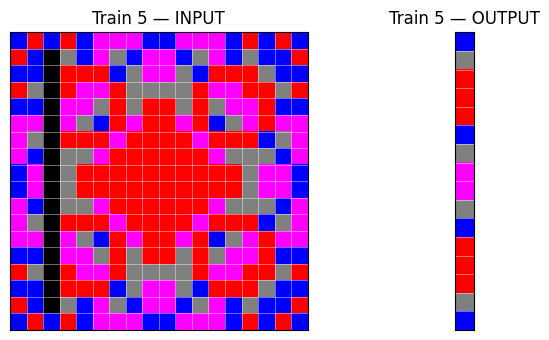


--- AUGMENTED: aug__rearc_9ecd008a__chunk01__rot90 (op=rot90) | pairs=5 ---


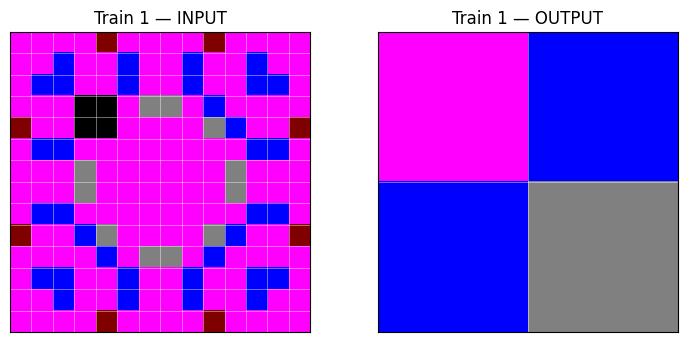

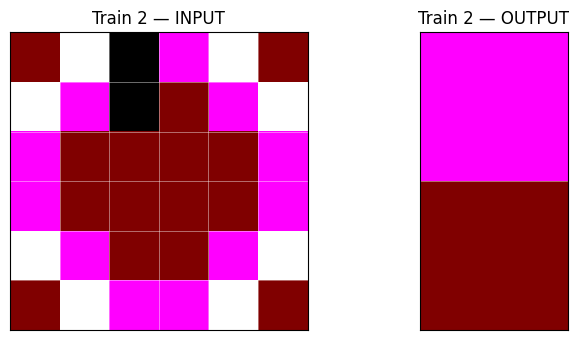

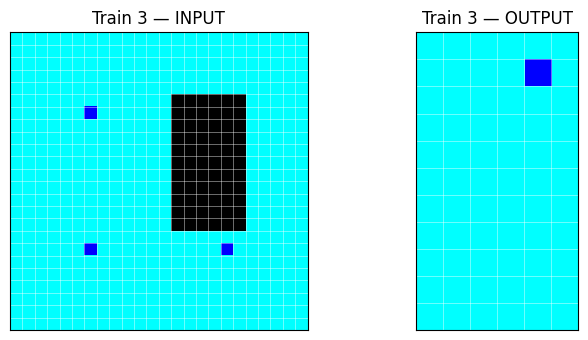

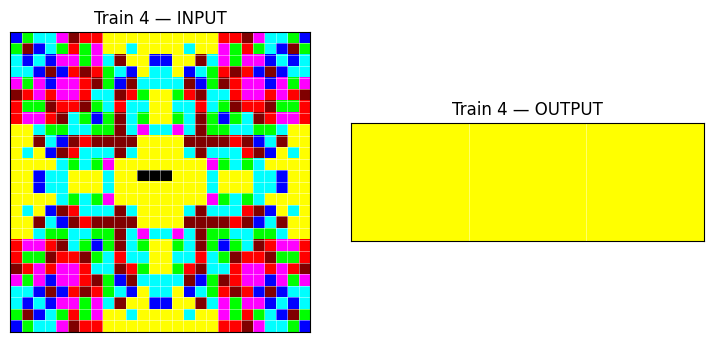

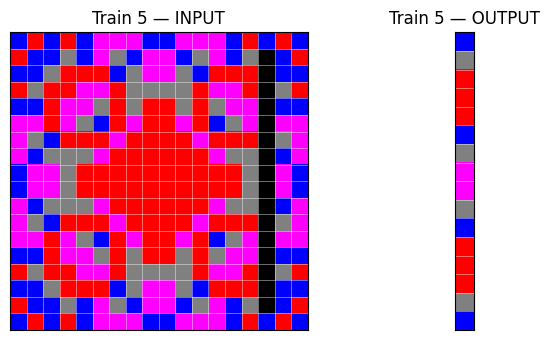


--- AUGMENTED: aug__rearc_9ecd008a__chunk01__transpose (op=transpose) | pairs=5 ---


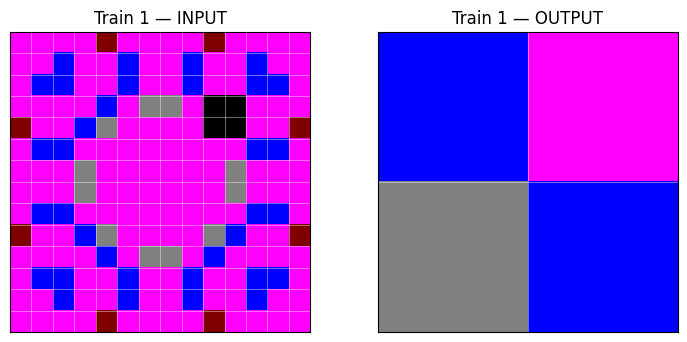

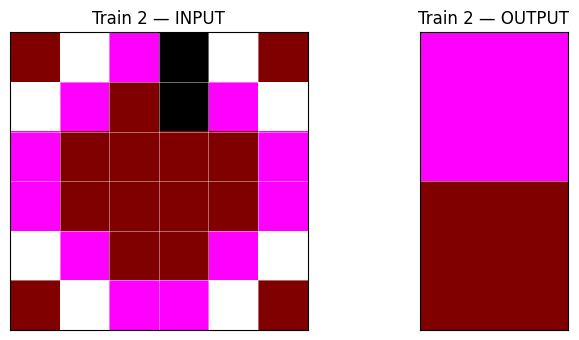

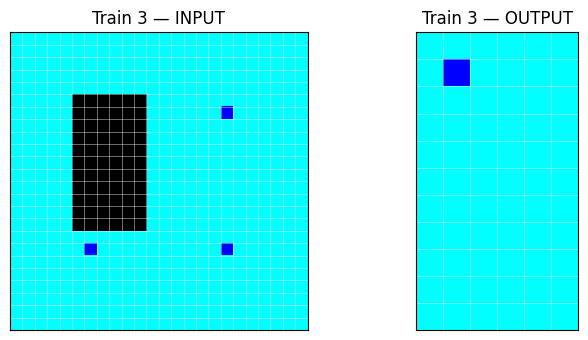

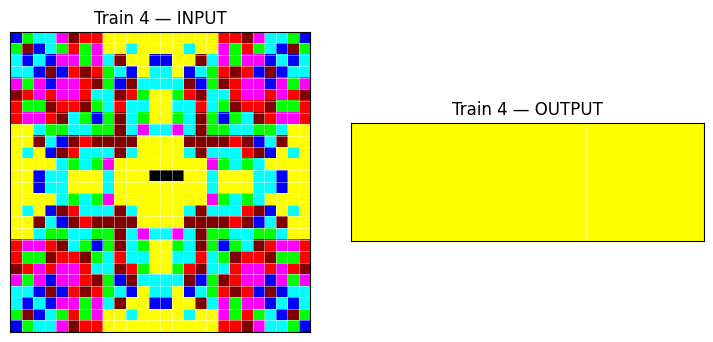

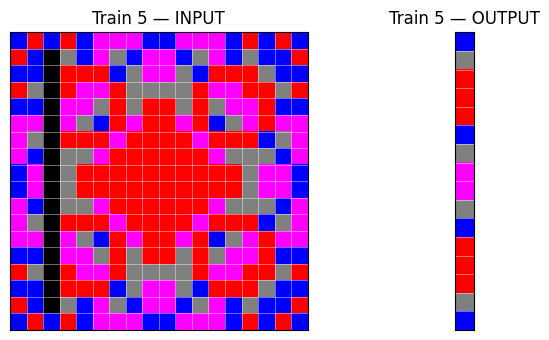

In [ ]:
import json

data = json.load(open("combined_with_geom_aug.json"))

# Pick a base task key (ARC example)
#visualize_base_and_augmented(data, base_key="arc_f76d97a5")

# Or a RE-ARC example (adjust to a key you have)
visualize_base_and_augmented(data, base_key="rearc_9ecd008a__chunk01")

##Supervised Fine-Tuning

### Prepare SFT Dataset

In [ ]:
SYSTEM_MSG = (
    "You are an ARC puzzle solver. You will be shown a few example input/output "
    "pairs and then a new input. Return only the output grid as a list of lists."
)

def grid_to_text(g: List[List[int]]) -> str:
    return "[\n  " + ",\n  ".join("[" + ", ".join(map(str, r)) + "]" for r in g) + "\n]"

def make_icl_messages(
    demos: List[Tuple[List[List[int]], List[List[int]]]],
    query_input: List[List[int]],
    system_msg: str = SYSTEM_MSG,
) -> List[Dict[str, str]]:
    """
    Build ICL chat messages with ≥1 demonstration.
    Returns [system, user]; append the assistant with gold elsewhere.
    """
    demos_txt = "\n".join(
        f"{i+1}) INPUT:\n{grid_to_text(x)}\n   OUTPUT:\n{grid_to_text(y)}"
        for i, (x, y) in enumerate(demos)
    )
    user = (
        "Demonstrations:\n" + demos_txt +
        "\n\nNow solve:\nINPUT:\n" + grid_to_text(query_input) +
        "\n\nReturn only the OUTPUT grid."
    )
    return [
        {"role": "system", "content": system_msg},
        {"role": "user",   "content": user},
    ]


def icl_partition_pairs(task: Dict) -> Tuple[
    List[Tuple[List[List[int]], List[List[int]]]],
    List[Tuple[List[List[int]], List[List[int]]]]
]:
    """
    Returns (demos, queries) as lists of (input_grid, output_grid).
      - ARC / aug-from-ARC: demos = split in {'train','all'}; queries = split == 'test'
      - REARC / aug-from-REARC: demos = all pairs except last; query = last
    Assumes RE-ARC tasks have ≥2 pairs.
    """
    pairs = task["pairs"]
    if task.get("source") == "arc":
        demos   = [(p["input"], p["output"]) for p in pairs if p.get("split") in {"train", "all"}]
        queries = [(p["input"], p["output"]) for p in pairs if p.get("split") == "test"]
    else:  # 'rearc'
        demos   = [(p["input"], p["output"]) for p in pairs[:-1]]
        queries = [(pairs[-1]["input"], pairs[-1]["output"])]
    return demos, queries


def build_sft_jsonl_from_combined_with_icl(
    combined_path: str,
    out_jsonl: str,
    *,
    include_augmented: bool = True,
    allow_sources = ("arc", "rearc"),
) -> None:
    """
    Reads combined_with_geom_aug.json and writes messages-only JSONL for SFT.
    One row per query (ARC: each test pair; RE-ARC: last pair).
    Each row includes [system, user, assistant(gold)] in 'messages'.
    """
    combined = json.load(open(combined_path))
    allow_sources = set(allow_sources)
    n_rows = 0

    with open(out_jsonl, "w") as f:
        for task_key in sorted(combined.keys()):
            if not include_augmented and task_key.startswith("aug__"):
                continue
            task = combined[task_key]
            if task.get("source") not in allow_sources:
                continue

            demos, queries = icl_partition_pairs(task)  # uses all demos by default
            if not demos or not queries:
                continue  # nothing to write

            for _, (x_query, y_query) in enumerate(queries):
                messages = make_icl_messages(demos, x_query)
                messages.append({"role": "assistant", "content": grid_to_text(y_query)})
                f.write(json.dumps({"messages": messages}, separators=(",", ":")) + "\n")
                n_rows += 1

    print(f"✅ SFT JSONL written: {out_jsonl}  | rows: {n_rows}")

In [ ]:
def build_eval_jsonl_from_old_schema_with_icl(
    challenges_path: str,
    solutions_path: str,
    out_jsonl: str,
) -> None:
    """
    Reads:
      - arc-agi_evaluation_challenges.json  (old schema)
      - arc-agi_evaluation_solutions.json   (old schema)
    For each task, demos = all TRAIN pairs; for each TEST input, create one row
    with [system, user, assistant(gold)] in 'messages'.
    """
    chal = json.load(open(challenges_path))   # {tid: {"train":[{input,output},...], "test":[{input},...]}}
    sols = json.load(open(solutions_path))    # {tid: [solution_grid_for_test1, ...]}
    n_rows = 0

    with open(out_jsonl, "w") as f:
        for tid in sorted(chal.keys()):
            task = chal[tid]
            demos = [(p["input"], p["output"]) for p in task.get("train", [])]  # all demos
            tests = [t["input"] for t in task.get("test", [])]
            golds = sols.get(tid, [])
            if not tests or len(tests) != len(golds):
                continue

            for j, x in enumerate(tests):
                y = golds[j]
                messages = make_icl_messages(demos, x)
                messages.append({"role": "assistant", "content": grid_to_text(y)})
                f.write(json.dumps({"messages": messages}, separators=(",", ":")) + "\n")
                n_rows += 1

    print(f"✅ Eval JSONL written: {out_jsonl}  | rows: {n_rows}")

In [ ]:
# 1) Train JSONL from your combined dataset (new schema)
build_sft_jsonl_from_combined_with_icl(
    combined_path="combined_with_geom_aug.json",
    out_jsonl="sft_train_icl.jsonl",
    include_augmented=True,   # keep augmented tasks
    allow_sources=("arc","rearc"),
)

# 2) Eval JSONL from old schema (evaluation challenges + solutions)
build_eval_jsonl_from_old_schema_with_icl(
    challenges_path="arc-agi_evaluation_challenges.json",
    solutions_path="arc-agi_evaluation_solutions.json",
    out_jsonl="sft_eval_icl.jsonl",
)

✅ SFT JSONL written: sft_train_icl.jsonl  | rows: 13902
✅ Eval JSONL written: sft_eval_icl.jsonl  | rows: 381


### Inspect SFT Data

In [ ]:
import json, itertools, textwrap

def peek_jsonl(path, n=2, wrap=100):
    print(f"\n== {path} ==")
    for i, line in enumerate(itertools.islice(open(path), n), 1):
        row = json.loads(line)
        msgs = row["messages"]
        roles = [m["role"] for m in msgs]
        print(f"\nRow {i}: roles={roles}")
        for j, m in enumerate(msgs):
            head = m["content"].strip().splitlines()[:200]  # first 200 lines
            head = "\n".join(textwrap.shorten(s, width=wrap) for s in head)
            print(f"  [{j}] {m['role']}:\n{head}\n")

peek_jsonl("sft_train_icl.jsonl", n=2)
peek_jsonl("sft_eval_icl.jsonl",  n=2)


== sft_train_icl.jsonl ==

Row 1: roles=['system', 'user', 'assistant']
  [0] system:
You are an ARC puzzle solver. You will be shown a few example input/output pairs and then a [...]

  [1] user:
Demonstrations:
1) INPUT:
[
[0, 7, 7],
[7, 7, 7],
[0, 7, 7]
]
OUTPUT:
[
[0, 0, 0, 0, 7, 7, 0, 7, 7],
[0, 0, 0, 7, 7, 7, 7, 7, 7],
[0, 0, 0, 0, 7, 7, 0, 7, 7],
[0, 7, 7, 0, 7, 7, 0, 7, 7],
[7, 7, 7, 7, 7, 7, 7, 7, 7],
[0, 7, 7, 0, 7, 7, 0, 7, 7],
[0, 0, 0, 0, 7, 7, 0, 7, 7],
[0, 0, 0, 7, 7, 7, 7, 7, 7],
[0, 0, 0, 0, 7, 7, 0, 7, 7]
]
2) INPUT:
[
[4, 0, 4],
[0, 0, 0],
[0, 4, 0]
]
OUTPUT:
[
[4, 0, 4, 0, 0, 0, 4, 0, 4],
[0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 4, 0, 0, 0, 0, 0, 4, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 4, 0, 4, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 4, 0, 0, 0, 0]
]
3) INPUT:
[
[0, 0, 0],
[0, 0, 2],
[2, 0, 2]
]
OUTPUT:
[
[0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 

In [ ]:
import json, re, statistics

DEMO_RE = re.compile(r"\n\d+\)\s*INPUT:")

def stats_jsonl(path, max_rows=None):
    n_rows = 0
    demo_counts, user_chars, assist_chars = [], [], []
    for n_rows, line in enumerate(open(path), 1):
        if max_rows and n_rows > max_rows: break
        row = json.loads(line)
        msgs = row["messages"]
        user = msgs[1]["content"]
        asst = msgs[-1]["content"]
        demos = len(DEMO_RE.findall(user))
        demo_counts.append(demos)
        user_chars.append(len(user))
        assist_chars.append(len(asst))
    if n_rows == 0:
        print(f"{path}: empty")
        return
    print(f"{path}: rows={n_rows}")
    print(f"  demos per row: mean={statistics.mean(demo_counts):.2f}, min={min(demo_counts)}, max={max(demo_counts)}")
    print(f"  user prompt chars: mean={statistics.mean(user_chars):.0f}, min={min(user_chars)}, max={max(user_chars)}")
    print(f"  assistant chars:   mean={statistics.mean(assist_chars):.0f}, min={min(assist_chars)}, max={max(assist_chars)}")

stats_jsonl("sft_train_icl.jsonl")
stats_jsonl("sft_eval_icl.jsonl")

sft_train_icl.jsonl: rows=13902
  demos per row: mean=3.84, min=2, max=8
  user prompt chars: mean=7438, min=316, max=25555
  assistant chars:   mean=743, min=9, max=2822
sft_eval_icl.jsonl: rows=381
  demos per row: mean=3.33, min=2, max=7
  user prompt chars: mean=5504, min=441, max=25555
  assistant chars:   mean=816, min=9, max=2822


In [ ]:
import json, random, pprint
pp = pprint.PrettyPrinter(width=100)

def show_random_row(path, seed=0):
    lines = open(path).read().splitlines()
    random.Random(seed).shuffle(lines)
    row = json.loads(lines[0])
    print(f"Random row from {path}:")
    pp.pprint(row)

show_random_row("sft_train_icl.jsonl", seed=42)

Random row from sft_train_icl.jsonl:
{'messages': [{'content': 'You are an ARC puzzle solver. You will be shown a few example '
                          'input/output pairs and then a new input. Return only the output grid as '
                          'a list of lists.',
               'role': 'system'},
              {'content': 'Demonstrations:\n'
                          '1) INPUT:\n'
                          '[\n'
                          '  [9, 9, 9, 9, 5, 9, 9],\n'
                          '  [9, 9, 9, 9, 5, 5, 9],\n'
                          '  [9, 5, 5, 9, 9, 9, 9],\n'
                          '  [9, 5, 9, 9, 5, 5, 9],\n'
                          '  [9, 9, 9, 9, 9, 5, 9],\n'
                          '  [9, 9, 9, 9, 9, 9, 9]\n'
                          ']\n'
                          '   OUTPUT:\n'
                          '[\n'
                          '  [9, 9, 9, 9, 5, 1, 9],\n'
                          '  [9, 9, 9, 9, 5, 5, 9],\n'
                          '  

In [ ]:
import json, numpy as np
from transformers import AutoTokenizer

TRAIN_JSONL = "sft_train_icl.jsonl"
EVAL_JSONL  = "sft_eval_icl.jsonl"

MODEL_ID = "Qwen/Qwen2.5-1.5B-Instruct"   # use the same model you’ll train
tok = AutoTokenizer.from_pretrained(MODEL_ID, use_fast=True)

def msg_len_tokens(messages, add_generation_prompt=False):
    text = tok.apply_chat_template(messages, add_generation_prompt=add_generation_prompt, tokenize=False)
    return len(tok(text).input_ids)

def lengths_from_jsonl(path, sample=None, add_generation_prompt=False, strip_assistant=False):
    lens = []
    for i, line in enumerate(open(path), 1):
        if sample and i > sample: break
        msgs = json.loads(line)["messages"]
        if strip_assistant:
            msgs = msgs[:-1]
        lens.append(msg_len_tokens(msgs, add_generation_prompt=add_generation_prompt))
    return np.array(lens, dtype=int)

def summarize(name, arr, budget=None):
    if len(arr) == 0:
        print(f"{name}: empty"); return
    p = np.percentile(arr, [50, 90, 95, 99, 100]).astype(int)
    print(f"\n{name}: n={len(arr)} | min={arr.min()} mean={int(arr.mean())} median={p[0]} "
          f"p90={p[1]} p95={p[2]} p99={p[3]} max={p[4]}")
    if budget is not None:
        over = int((arr > budget).sum())
        print(f"  > budget {budget}: {over} ({over/len(arr):.1%})")

# Teacher-forced (training/eval) token lengths
train_tf = lengths_from_jsonl(TRAIN_JSONL, sample=None, add_generation_prompt=False, strip_assistant=False)
eval_tf  = lengths_from_jsonl(EVAL_JSONL,  sample=None, add_generation_prompt=False, strip_assistant=False)
summarize("TRAIN (teacher-forced)", train_tf)
summarize("EVAL  (teacher-forced)", eval_tf)

# Inference-style prompts (strip gold; add generation head)
train_inf = lengths_from_jsonl(TRAIN_JSONL, sample=None, add_generation_prompt=True, strip_assistant=True)
eval_inf  = lengths_from_jsonl(EVAL_JSONL,  sample=None, add_generation_prompt=True, strip_assistant=True)
summarize("TRAIN prompts for inference", train_inf)
summarize("EVAL  prompts for inference", eval_inf)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]


TRAIN (teacher-forced): n=13902 | min=270 mean=7681 median=7454 p90=13087 p95=14444 p99=17097 max=27412

EVAL  (teacher-forced): n=381 | min=402 mean=5930 median=4237 p90=12801 p95=16470 p99=23035 max=27412

TRAIN prompts for inference: n=13902 | min=236 mean=6978 median=6810 p90=11866 p95=13194 p99=15546 max=24678

EVAL  prompts for inference: n=381 | min=346 mean=5153 median=3674 p90=11130 p95=14196 p99=20301 max=24678
